# The Inception Model
In our project, we have developed a sophisticated deep learning model based on Inception architecture to address a critical agricultural challenge – the early detection of diseases in important crops like tomato, potato, and maize. The model's primary objective is to accurately distinguish between healthy leaves and leaves infected with diseases, enabling farmers and researchers to take timely preventive measures and ensure crop health.

By leveraging the power of deep learning, our Inception model analyzes intricate patterns and features in leaf images, providing a rapid and precise diagnosis. The capability to identify diseases in multiple crops - tomato, potato, and maize - enhances its versatility and applicability in various agricultural settings. 

In [1]:
#importing the relevant packages
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from re import sub

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
batch_size = 32 #batch size for images
image_size = (256,256) #size of image

dataset_path = 'data'

## Splitting into train and validation datasets

In [3]:
train_ds = image_dataset_from_directory(dataset_path, batch_size= batch_size,
                                        shuffle = True, validation_split= 0.2,
                                        seed = 123, label_mode= 'categorical',
                                        image_size= image_size, subset= 'training')

Found 25631 files belonging to 19 classes.
Using 20505 files for training.


In [4]:
val_ds = image_dataset_from_directory(dataset_path,batch_size= batch_size,
                                        shuffle = True, validation_split= 0.2,
                                        seed = 123, label_mode= 'categorical',
                                        image_size= image_size, subset= 'validation')

Found 25631 files belonging to 19 classes.
Using 5126 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes # number of classes in the dataset

19

In [6]:
class_names #classes

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___Northern_Leaf_Blight_oversampled',
 'Corn_(maize)___Northern_Leaf_Blight_undersampled',
 'Corn_(maize)___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

## Data Preprocessing

To evaluate the performance of our model on unseen data (test dataset) while training the model on the rest of the data (training dataset), the **validation dataset** will be split into two parts:

* one-fifth of the batches are extracted to create a separate **test dataset** for testing purposes.
* the remaining batches are kept in the validation dataset for training or other processing.

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

To enable the TensorFlow model to dynamically adjust the number of CPU or GPU resources used for data loading operations, we'll use a special constant called **AUTOTUNE.** This will make the data input pipeline more efficient.

In [8]:
#declaring autotune variable
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
To improve model performance, we added some data augmentation.

In [9]:
#augmentations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.GaussianNoise(0.1),
])

A brief description of the augmentations added:

* **tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')**: This line creates a preprocessing layer that performs random horizontal flips on the input data. When applied to an image, it randomly flips the image horizontally with a 50% probability. 
* **tf.keras.layers.experimental.preprocessing.RandomRotation(0.2):** This line adds another preprocessing layer that performs random rotations to the input data.
* **tf.keras.layers.experimental.preprocessing.RandomZoom(0.2):** This layer randomly zooms the input data, allowing for a zoom range of 0.0 to 0.2.

* **tf.keras.layers.GaussianNoise(0.1):** This layer adds random Gaussian noise to the input data with a standard deviation of 0.1.

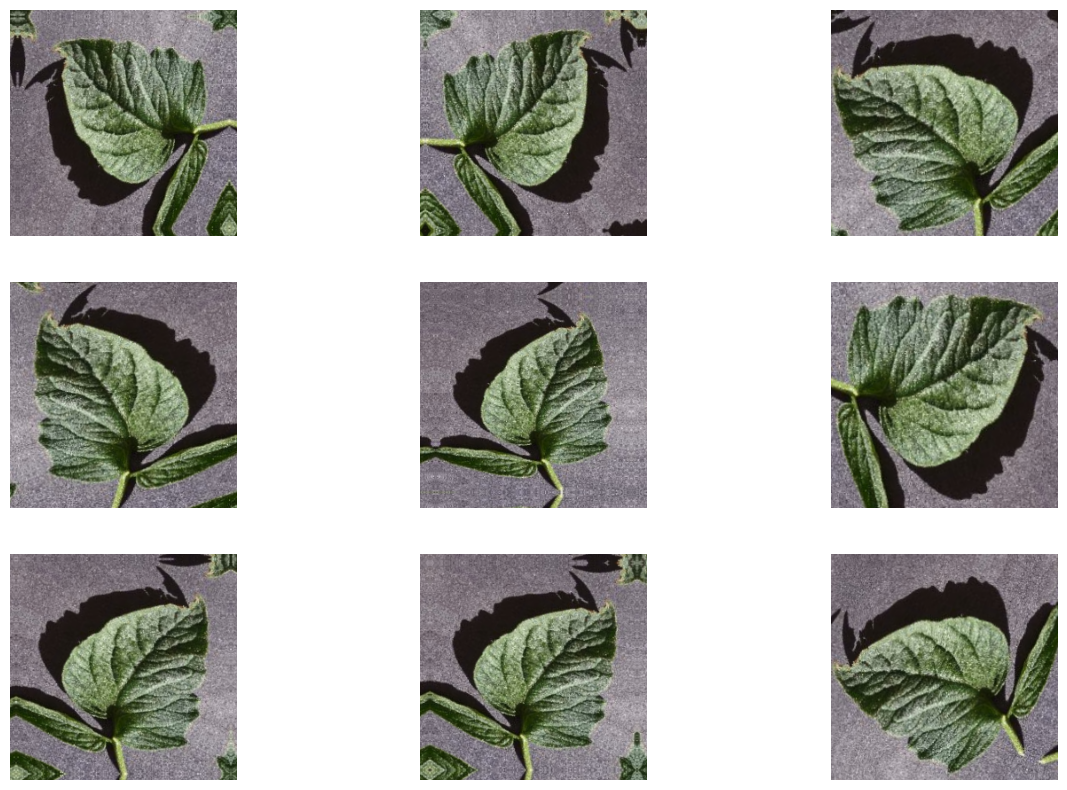

In [10]:
for images, _ in train_ds.take(1):
    sample_image = images[0]

# Creating a grid for displaying augmented images
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

In [11]:
def plot_metrics(history):
    """
    Plotting training and validation metrics for specified metrics.
    """
    # Define colors and metrics to plot
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    metrics = ['loss', 'auc', 'precision', 'recall']
    
    # Creating a figure for plotting metrics
    plt.figure(figsize=(20, 10))
    
    # Loop through metrics and plot training and validation values
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()  # Format metric name for display
        plt.subplot(2, 2, n + 1)  # Create subplots for each metric
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        # Set y-axis limits based on the metric
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
    
        plt.legend()  # Display legend for train and validation lines

In [12]:
#metrics for our model
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

## Baseline Model

In [13]:
image_shape = image_size + (3,) #for 3 color channels RGB (Red, Green, Blue) 

For this modelling, we'll use InceptionResNetV2 model, which is a pre-trained convolutional neural network (CNN) architecture for image recognition.

The `.preprocess_input` is a function specific to the InceptionResNetV2 model used to preprocess input images before they are fed into the neural network for prediction. The preprocessing involves resizing the image to the input size expected by the model and performing normalization and other necessary transformations.

In [14]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

By assigning `preprocess_input` to tf.keras.applications.inception_resnet_v2.preprocess_input, we are creating a reference to this preprocessing function.

### Creating an instance of the InceptionResNetV2 model using TensorFlow's Keras API.

In [15]:
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=image_shape,
                            )

In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1536)


The printed shape provides insight into the dimensionality of the features extracted by the model, which can be useful for further processing or building subsequent layers in our neural network.

### Freezing Pre-trained Layers

In [17]:
base_model.trainable = False

By setting trainable to False, it means that the weights of the layers in the base_model will not be updated during the training process. Essentially, the model becomes a fixed feature extractor, and only the additional layers that you add on top of this base model will be trained.

### Global average pooling

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


The **GlobalAveragePooling2D** layer performs global average pooling on the spatial dimensions of the input tensor. For each feature map in the input tensor, it calculates the average value of all the elements in that feature map. Global average pooling is a technique often used in convolutional neural networks for downsampling and reducing the spatial dimensions of the feature maps.

The shape of feature_batch_average represents the dimensions of the tensor obtained after applying global average pooling. 

### Adding prediction layer

In [19]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 19)


In the code above, a dense layer for predictions is created, applied to the output obtained after global average pooling, and then the shape of the resulting tensor is printed. 

### Setting up the TensorFlow Keras model for image classification using transfer learning

In [20]:
inputs = tf.keras.Input(shape=(256, 256, 3)) #defines input shape

x = data_augmentation(inputs) #input images go through data augmentation
x = preprocess_input(x) #images are further preprocessed
x = base_model(x, training=False) #the preprocessed images go through the base_model, which is the InceptionResNetV2 model.
x = global_average_layer(x) #output from the base_model goes through a global average pooling layer
x = tf.keras.layers.Dropout(0.2)(x) #dropout regularization is added to prevent overfitting

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

This code sets up a complete image classification model using transfer learning with InceptionResNetV2 as the base model. The model takes 256x256 RGB images as input, applies data augmentation and preprocessing, extracts features using the pre-trained InceptionResNetV2, performs global average pooling and dropout for regularization, and finally produces classification predictions for a specific task.

In [21]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

Here, the model is compiled with the following configuration:

**Optimizer:** The Adam optimizer is used. Adam is an adaptive learning rate optimization algorithm that combines the advantages of both AdaGrad and RMSProp. It adjusts the learning rates of each parameter individually, allowing for faster convergence. The learning rate is set to base_learning_rate (0.001 in this case).

**Loss Function:** The categorical crossentropy loss function is used. Categorical crossentropy is commonly used in multi-class classification problems. The from_logits=True argument indicates that the model's output is not normalized (i.e., the raw logits are used), and the softmax activation function will be applied internally during the computation of the loss. This is often used for numerical stability.

**Metrics:** The METRICS variable, which likely contains a list of metrics such as accuracy, precision, recall, etc., is specified as the metrics to be monitored during training. These metrics will be used to evaluate the model's performance during training and validation.

### Base model summary
The function `.summary()` in TensorFlow provides a textual summary of the architecture of the neural network model.

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

### Training, Validating then Testing

In [23]:
# Defining the train_step function outside the interactive environment to silence warning after fitting
@tf.autograph.experimental.do_not_convert
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = compute_loss(labels, predictions) 

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [24]:
initial_epochs = 10

In [25]:
# Inside your training loop or model.fit() call
base_history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/10
641/641 [==============================] - 305s 454ms/step - loss: 1.1197 - accuracy: 0.6308 - precision: 0.8522 - recall: 0.4495 - auc: 0.9638 - val_loss: 0.8606 - val_accuracy: 0.7189 - val_precision: 0.8230 - val_recall: 0.5933 - val_auc: 0.9785
Epoch 2/10
641/641 [==============================] - 288s 450ms/step - loss: 0.7458 - accuracy: 0.7441 - precision: 0.8560 - recall: 0.6284 - auc: 0.9837 - val_loss: 0.7067 - val_accuracy: 0.7503 - val_precision: 0.8838 - val_recall: 0.6368 - val_auc: 0.9850
Epoch 3/10
641/641 [==============================] - 288s 450ms/step - loss: 0.6647 - accuracy: 0.7696 - precision: 0.8630 - recall: 0.6745 - auc: 0.9867 - val_loss: 0.6180 - val_accuracy: 0.7821 - val_precision: 0.8912 - val_recall: 0.6873 - val_auc: 0.9881
Epoch 4/10
641/641 [==============================] - 289s 451ms/step - loss: 0.6216 - accuracy: 0.7789 - precision: 0.8624 - recall: 0.7041 - auc: 0.9881 - val_loss: 0.6317 - val_accuracy: 0.7704 - val_precision: 0.8354

#### Plotting accuracy/validation accuracy and loss/validation loss

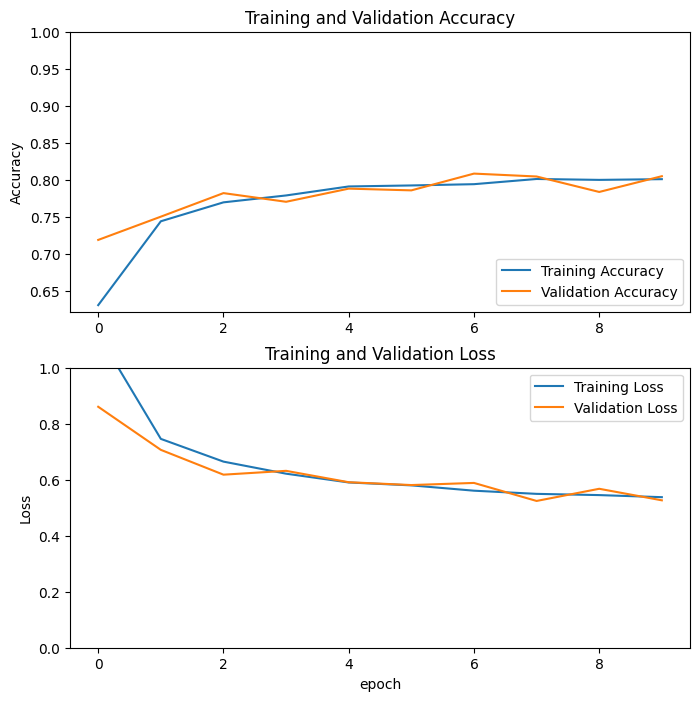

In [26]:
#plotting accuracy and validation accuracy
acc = base_history.history['accuracy']
val_acc = base_history.history['val_accuracy']

loss = base_history.history['loss']
val_loss = base_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

#plotting loss and validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

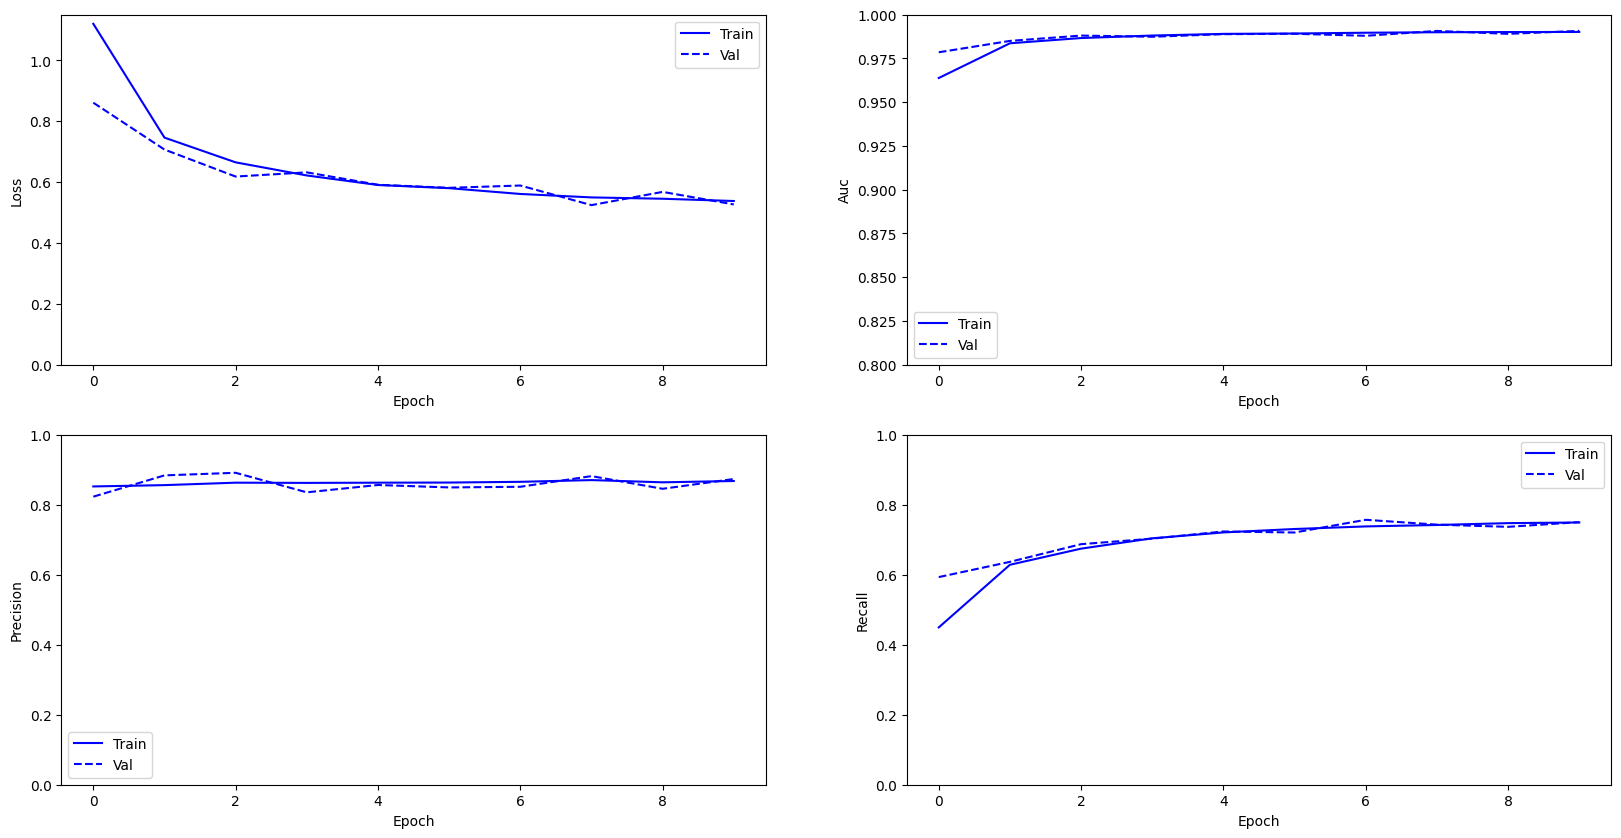

In [27]:
#applying the plotting function from earlier
plot_metrics(base_history)

## Tuning The model

In [28]:
base_model.trainable = True

The code above allows us to fine-tune the pre-trained model.

In [29]:
#Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 650

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [30]:
#compiling the model with the fine tuned learning rate
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

In [32]:
len(model.trainable_variables)

84

In [33]:
#number of epochs to tune
tune_epochs = 20
total_epochs =  initial_epochs + tune_epochs

#fitting the model on the train ds again 
final_history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=base_history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/30
641/641 [==============================] - 330s 489ms/step - loss: 0.4054 - accuracy: 0.8355 - precision: 0.9029 - recall: 0.7855 - auc: 0.9937 - val_loss: 0.3275 - val_accuracy: 0.8658 - val_precision: 0.9374 - val_recall: 0.8209 - val_auc: 0.9964
Epoch 11/30
641/641 [==============================] - 310s 484ms/step - loss: 0.3187 - accuracy: 0.8693 - precision: 0.9332 - recall: 0.8276 - auc: 0.9964 - val_loss: 0.2898 - val_accuracy: 0.8761 - val_precision: 0.9440 - val_recall: 0.8383 - val_auc: 0.9971
Epoch 12/30
641/641 [==============================] - 310s 483ms/step - loss: 0.2727 - accuracy: 0.8859 - precision: 0.9440 - recall: 0.8495 - auc: 0.9973 - val_loss: 0.2696 - val_accuracy: 0.8810 - val_precision: 0.9514 - val_recall: 0.8474 - val_auc: 0.9973
Epoch 13/30
641/641 [==============================] - 309s 482ms/step - loss: 0.2410 - accuracy: 0.8956 - precision: 0.9519 - recall: 0.8615 - auc: 0.9978 - val_loss: 0.2768 - val_accuracy: 0.8804 - val_precision: 0.

### Plotting the accuracy/val_accuracy and loss/val_loss

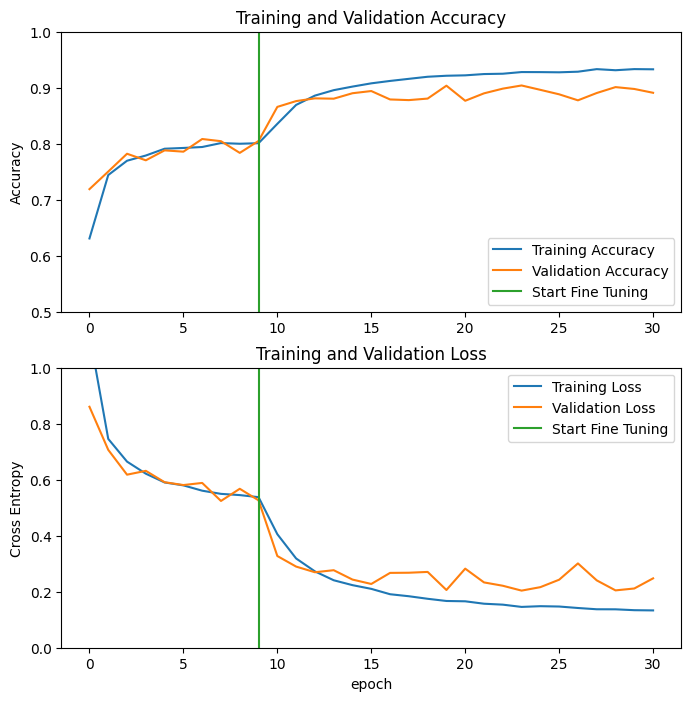

In [34]:
#plotting the accuracy/val_accuracy and loss/val_loss
acc += final_history.history['accuracy']
val_acc += final_history.history['val_accuracy']

loss += final_history.history['loss']
val_loss += final_history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

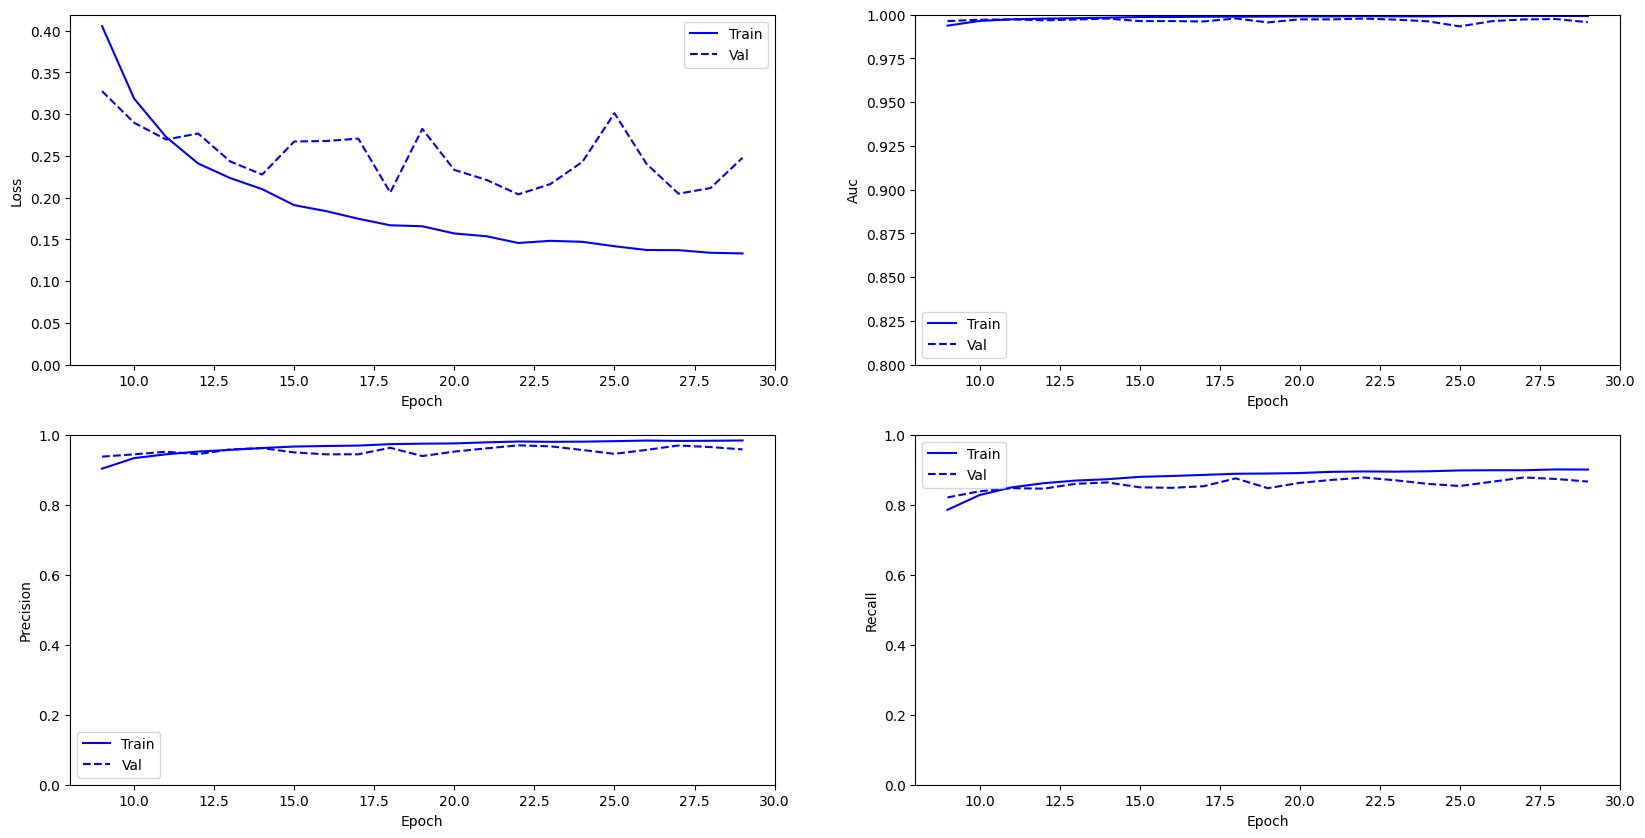

In [35]:
#applying plotting function
plot_metrics(final_history)

## Testing the model

In [36]:
#testing on unseen data
results = model.evaluate(test_dataset)

32/32 [==============================] - 13s 390ms/step - loss: 0.2421 - accuracy: 0.8906 - precision: 0.9600 - recall: 0.8682 - auc: 0.9962


In [39]:
#printing the metrics
metrics = ["loss", "accuracy", "precision", "recall", "auc"]
for i in range(len(results)):
    print("{} : {}".format(metrics[i],round(results[i], 3)))

loss : 0.242
accuracy : 0.891
precision : 0.96
recall : 0.868
auc : 0.996


### Calculating f1 score of the result

In [41]:
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

precision = results[2]
recall = results[3]

# Calculate F1 score
f1_score = calculate_f1_score(precision, recall)

# Print the result
print("F1 Score:", f1_score)

F1 Score: 0.9117948697046886


Our model, has achieved an impressive F1 score of 0.911 in classifying leaves as healthy or diseased. This high F1 score signifies that the model is accurate, sensitive, and precise in its predictions. We are pleased with its performance, indicating that it strikes a good balance between correctly identifying diseased leaves (high recall) and avoiding misclassifying healthy leaves as diseased (high precision). This outcome demonstrates the effectiveness of our Inception model in accurately categorizing leaves and underscores its potential for real-world applications in plant health monitoring and disease detection.

## Visualizing Predictions on Images

Predictions:
 [1, 15, 2, 9, 13, 17, 5, 18, 5, 1, 18, 2, 16, 1, 16, 16, 16, 2, 9, 9, 16, 18, 18, 2, 1, 18, 16, 16, 13, 6, 2, 2]
Labels:
 [1, 15, 3, 9, 13, 17, 5, 18, 5, 1, 18, 3, 16, 1, 16, 16, 16, 4, 9, 9, 16, 18, 18, 2, 1, 18, 16, 16, 13, 6, 4, 2]


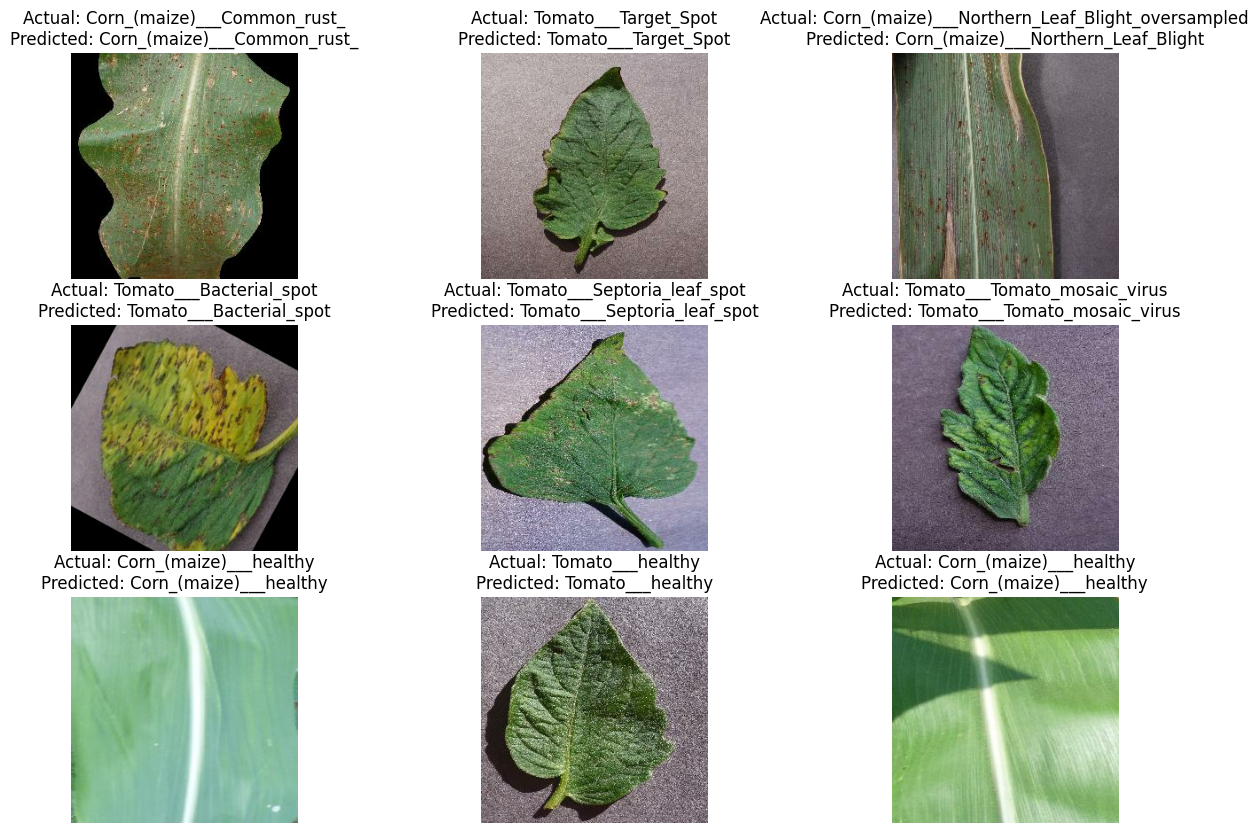

In [58]:
# Making predictions on sample batch dataset with actual names and predicted
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

#plotting the images with predictions and actual
print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(15, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[np.argmax(label_batch[i])]
    predicted_label = class_names[predictions[i]]
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    plt.axis("off")

plt.show()

## Saving the model

In [59]:
models.save_model(model, "./inception_lazarus")

INFO:tensorflow:Assets written to: ./inception_lazarus\assets


INFO:tensorflow:Assets written to: ./inception_lazarus\assets
